# Initial Settings

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import jalali
import statistics
import plotly.graph_objects as go
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import voronoi_diagram as svd
from shapely.wkt import loads as load_wkt
from datetime import datetime
from tabulate import tabulate

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)


# Modify Date And Water Table
# Date Type: 
#   1.Gregorian (Text): 2000-11-1
#   2.Persian (Text): 1399-1-1
# Date & Value:
#   Column of Pandas Dataframe
def convert_to_day_15(info, date, value, date_type="persian"):
    """[summary]

    Args:
        info ([type]): [description]
        date ([type]): [description]
        value ([type]): [description]
        date_type (str, optional): [description]. Defaults to "persian".

    Returns:
        [type]: [description]
    """
    df = info.copy()
    if date_type == "gregorian":
        df["DATE_GREGORIAN"] = date.apply(pd.to_datetime)
        df["DATE_PERSIAN"] = list(
            map(
                lambda i: jalali.Gregorian(i.date()).persian_string(),
                df["DATE_GREGORIAN"]
            )
        )
    elif date_type == "persian":
        df["DATE_PERSIAN"] = date
        df["DATE_GREGORIAN"] = list(
            map(
                lambda i: jalali.Persian(i).gregorian_string(),
                df["DATE_PERSIAN"]
            )
        )
        df["DATE_GREGORIAN"] = df["DATE_GREGORIAN"].apply(pd.to_datetime)    
    else:
        pass
    df["VALUE"] = value        
    df["DELTA_DAY"] = df["DATE_GREGORIAN"].diff().dt.days
    df["DATE_PERSIAN_NEW"] = list(
        map(
            lambda i: f"{int(i.split('-')[0])}-{int(i.split('-')[1])}-{15}",
            df["DATE_PERSIAN"]
        )
    )
    df["DATE_GREGORIAN_NEW"] = list(
        map(
            lambda i: jalali.Persian(i).gregorian_string(),
            df["DATE_PERSIAN_NEW"]
        )
    )
    df["DATE_GREGORIAN_NEW"] = df["DATE_GREGORIAN_NEW"].apply(pd.to_datetime)
    df["VALUE_NEW"] = df["VALUE"]
    A = []
    A.append(df["VALUE"][0])
    for i in range(1, len(df)):
        if int(df["DATE_PERSIAN"][i].split('-')[2]) >= 15:
            NEW_VALUE = df["VALUE"][i-1] + ((((df["DATE_GREGORIAN_NEW"][i] - df["DATE_GREGORIAN"][i-1]).days) / ((df["DATE_GREGORIAN"][i] - df["DATE_GREGORIAN"][i-1]).days)) * (df["VALUE"][i] - df["VALUE"][i-1]))
            A.append(NEW_VALUE)
        else:
            NEW_VALUE = df["VALUE"][i] + ((((df["DATE_GREGORIAN_NEW"][i] - df["DATE_GREGORIAN"][i]).days) / ((df["DATE_GREGORIAN"][i+1] - df["DATE_GREGORIAN"][i]).days)) * (df["VALUE"][i+1] - df["VALUE"][i]))
            A.append(NEW_VALUE)
    df["VALUE_NEW"] = A
    return df


def create_date_day15(min, max):
    """[summary]

    Args:
        min ([type]): [description]
        max ([type]): [description]

    Returns:
        [type]: [description]
    """
    result = []
    min_list = list(map(lambda x: int(x), min.split("-")))
    max_list = list(map(lambda x: int(x), max.split("-")))
    for y in range(min_list[0], max_list[0] + 1):
        for m in range(1, 13):
            result.append(f"{y}-{m}-15")

    result = pd.DataFrame(
        {"DATE_PERSIAN" : result}
    )
    result['DATE_GREGORIAN'] = result.apply(
        lambda x: jalali.Persian(x["DATE_PERSIAN"]).gregorian_string(), 
        axis=1
    )
    result["DATE_GREGORIAN"] = result["DATE_GREGORIAN"].apply(pd.to_datetime)
    result = result[result["DATE_GREGORIAN"] >= pd.to_datetime(jalali.Persian(min).gregorian_string())]
    result = result[result["DATE_GREGORIAN"] <= pd.to_datetime(jalali.Persian(max).gregorian_string())]
    result["DATE_GREGORIAN"] = result["DATE_GREGORIAN"].apply(pd.to_datetime)  
    return result


def dropHolesBase(plg):

	'''

	BASIC FUNCTION TO REMOVE / DROP / FILL THE HOLES.

	PARAMETERS:

		plg: plg WHO HAS HOLES / EMPTIES.
			Type: shapely.geometry.MultiPolygon OR shapely.geometry.Polygon

	RETURNS:
		A shapely.geometry.MultiPolygon OR shapely.geometry.Polygon object
	

	'''

	if isinstance(plg, MultiPolygon):

		return MultiPolygon(Polygon(p.exterior) for p in plg)

	elif isinstance(plg, Polygon):

		return Polygon(plg.exterior)


def dropHoles(gdf):

	'''

	REMOVE / DROP / FILL THE HOLES / EMPTIES FOR ITERMS IN GeoDataFrame.
	
	PARAMETERS:
		gdf:
			Type: geopandas.GeoDataFrame

	RETURNS:
		gdf_nohole: GeoDataFrame WITHOUT HOLES
			Type: geopandas.GeoDataFrame
	
	'''

	gdf_nohole = gpd.GeoDataFrame()

	for g in gdf['geometry']:

		geo = gpd.GeoDataFrame(geometry=gpd.GeoSeries(dropHolesBase(g)))

		gdf_nohole=gdf_nohole.append(geo,ignore_index=True)

	gdf_nohole.rename(columns={gdf_nohole.columns[0]:'geometry'}, inplace=True)

	gdf_nohole.crs = gdf.crs

	gdf.rename(columns={'geometry': 'geometry_old'}, inplace=True)

	gdf["geometry_new"] = gdf_nohole

	gdf.rename(columns={'geometry_new': 'geometry'}, inplace=True)

	gdf.drop(['geometry_old'], axis=1, inplace=True)

	return gdf


def thiessen_polygons(gdf, mask):

	'''

	CREATE VORONOI DIAGRAM / THIESSEN POLYGONS:

	PARAMETERS:

		gdf: POINTS / POLYGONS TO BE USED TO CREATE VORONOI DIAGRAM / THIESSEN POLYGONS.
            Type: geopandas.GeoDataFrame

		mask: POLYGON VECTOR USED TO CLIP THE CREATED VORONOI DIAGRAM / THIESSEN POLYGONS.
			Type: GeoDataFrame, GeoSeries, (Multi)Polygon

	RETURNS:

		gdf_vd: THIESSEN POLYGONS
			Type: geopandas.geodataframe.GeoDataFrame
	
	'''
	
	gdf.reset_index(drop=True)

	# CONVERT TO shapely.geometry.MultiPolygon
	smp = gdf.unary_union

	# CREATE PRIMARY VORONOI DIAGRAM BY INVOKING shapely.ops.voronoi_diagram
	poly = load_wkt('POLYGON ((42 24, 64 24, 64 42, 42 42, 42 24))')
	smp_vd = svd(smp, envelope=poly)

	# CONVERT TO GeoSeries AND explode TO SINGLE POLYGONS
	gs = gpd.GeoSeries([smp_vd]).explode()

	# CONVERT TO GEODATAFRAME
	# NOTE THAT IF GDF WAS shapely.geometry.MultiPolygon, IT HAS NO ATTRIBUTE 'crs'
	gdf_vd_primary = gpd.geodataframe.GeoDataFrame(geometry=gs, crs=gdf.crs)
	
	# RESET INDEX
	gdf_vd_primary.reset_index(drop=True)
	
	# SPATIAL JOIN BY INTERSECTING AND DISSOLVE BY `index_right`
	gdf_temp = (gpd.sjoin(gdf_vd_primary, gdf, how='inner', op='intersects').dissolve(by='index_right').reset_index(drop=True))

	gdf_vd = gpd.clip(gdf_temp, mask)

	gdf_vd = dropHoles(gdf_vd)

	return gdf_vd

# Read Data

## Read Data And GeoInfo

In [2]:
xls = pd.ExcelFile('Data/CSV/HydrographData.xlsx')
Data = pd.read_excel(xls, sheet_name='Data')
GeoInfo = pd.read_excel(xls, sheet_name='GeoInfo')

# GeoInfo
COLs = ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'LOCATION_NAME']
GeoInfo[COLs] = GeoInfo[COLs].apply(lambda x: x.str.rstrip())
GeoInfo[COLs] = GeoInfo[COLs].apply(lambda x: x.str.lstrip())

# Data
COLs = ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'LOCATION_NAME']
Data[COLs] = Data[COLs].apply(lambda x: x.str.rstrip())
Data[COLs] = Data[COLs].apply(lambda x: x.str.lstrip())

In [3]:
Data

,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,DATA_STATE,DATE_PERSIAN_RAW,DATE_GREGORIAN_RAW,WATER_TABLE_RAW,NO_MEASURE_CODE,INFO,STORAGE_COEFFICIENT_LOCATION,THISSEN_LOCATION,THISSEN_AQUIFER
0,سرخس,6004,سرخس,نوار مرزی-14,O,1367-4-9,NaN,11.97,NaN,NaN,0.09,NaN,NaN
1,سرخس,6004,سرخس,نوار مرزی-14,O,1367-5-20,NaN,11.91,NaN,NaN,0.09,NaN,NaN
2,سرخس,6004,سرخس,نوار مرزی-14,O,1367-6-22,NaN,11.93,NaN,NaN,0.09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13099,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,M,1383-5-19,NaN,NaN,NaN,NaN,0.09,NaN,NaN
13100,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,M,1383-6-27,NaN,NaN,NaN,NaN,0.09,NaN,NaN
13101,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,O,1393-4-21,NaN,25.34,NaN,NaN,0.09,NaN,NaN


In [4]:
GeoInfo

,INDEX,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,XUTM,YUTM,ZONEUTM,X,Y,MIN_YEAR,MAX_YEAR,LEVEL_MSL,LEVEL_SRTM
0,1,سرخس,6004,سرخس,اراضی حسن آباد جر -wb,324655,4045424,41,61.04,36.54,NaN,NaN,272,272
1,2,سرخس,6004,سرخس,اول کچولی,328501,4036848,41,61.09,36.46,NaN,NaN,290,290
2,3,سرخس,6004,سرخس,ایستگاه کنترل گاز,328548,4022853,41,61.09,36.34,NaN,NaN,347,347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,44,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,325084,4045190,41,61.05,36.54,NaN,NaN,276,276
44,45,سرخس,6004,سرخس,پشت فرودگاه قدیم - 7,332848,4042633,41,61.13,36.51,NaN,NaN,279,279
45,46,سرخس,6004,سرخس,قبل از نوروزآباد- اس 9,334051,4018988,41,61.15,36.30,NaN,NaN,321,321


## LOAD SHAPEFILES

In [5]:
gdf = gpd.read_file("Data/GeoJson/Sarakhs_Points.geojson")
gdf = gdf.set_crs("EPSG:32641", allow_override=True)

mask = gpd.read_file("Data/GeoJson/Sarakhs_Aquifer.geojson")
mask = mask.set_crs("EPSG:32641", allow_override=True)

<AxesSubplot:>

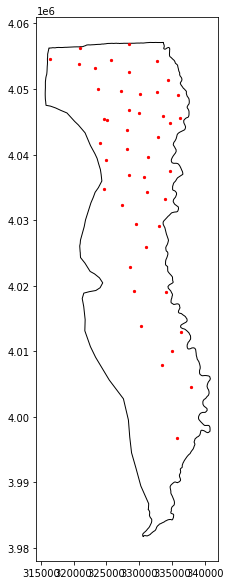

In [6]:
ax = mask.plot(color='white', edgecolor='black', figsize=(10,10))
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

# Convert Date

In [7]:
Data["DATE_GREGORIAN_RAW"] = Data["DATE_GREGORIAN_RAW"].apply(pd.to_datetime)

Data['DATE_CHECK'] = np.where(
    Data["DATE_PERSIAN_RAW"].isna(),
    np.where(
        Data["DATE_GREGORIAN_RAW"].isna(),
        np.NaN,
        "G"
    ),
    "P"  
)

Data['DATE_PERSIAN_RAW'] = Data.apply(
    lambda x: jalali.Gregorian(x["DATE_GREGORIAN_RAW"].date()).persian_string() if x["DATE_CHECK"] == "G" else x["DATE_PERSIAN_RAW"], 
    axis=1
)

Data['DATE_GREGORIAN_RAW'] = Data.apply(
    lambda x: jalali.Persian(x["DATE_PERSIAN_RAW"]).gregorian_string() if x["DATE_CHECK"] == "P" else x["DATE_GREGORIAN_RAW"], 
    axis=1
)

Data["DATE_GREGORIAN_RAW"] = Data["DATE_GREGORIAN_RAW"].apply(pd.to_datetime)


Data.drop(['DATE_CHECK'], axis=1, inplace=True)

Data.sort_values(
    by=["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", "DATE_GREGORIAN_RAW"], 
    inplace=True
)

In [8]:
Data

,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,DATA_STATE,DATE_PERSIAN_RAW,DATE_GREGORIAN_RAW,WATER_TABLE_RAW,NO_MEASURE_CODE,INFO,STORAGE_COEFFICIENT_LOCATION,THISSEN_LOCATION,THISSEN_AQUIFER
678,سرخس,6004,سرخس,s.6,O,1361-1-25,1982-04-14,3.91,NaN,NaN,0.09,NaN,NaN
679,سرخس,6004,سرخس,s.6,O,1361-2-18,1982-05-08,3.76,NaN,NaN,0.09,NaN,NaN
680,سرخس,6004,سرخس,s.6,O,1361-4-28,1982-07-19,4.95,NaN,NaN,0.09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12859,سرخس,6004,سرخس,یاس تپه راه جنگل,O,1399-12-3,2021-02-21,23.46,NaN,NaN,0.09,NaN,NaN
12860,سرخس,6004,سرخس,یاس تپه راه جنگل,O,1400-1-11,2021-03-31,23.72,NaN,NaN,0.09,NaN,NaN
12861,سرخس,6004,سرخس,یاس تپه راه جنگل,O,1400-2-15,2021-05-05,23.72,NaN,NaN,0.09,NaN,NaN


# Gap Filling

## Convert To Day 15

In [9]:
# Remove NanN Data In Column "WATER_TABLE_RAW"
Data.dropna(
    subset=["WATER_TABLE_RAW"],
    inplace=True
)

Data.reset_index(
    inplace=True,
    drop=True
)

wt_date_converted = convert_to_day_15(
    info=Data[["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME"]],
    date=Data["DATE_PERSIAN_RAW"],
    value=Data["WATER_TABLE_RAW"],
    date_type="persian"
)[["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", "DATE_PERSIAN", "DATE_PERSIAN_NEW", "DATE_GREGORIAN", "DATE_GREGORIAN_NEW", "VALUE_NEW"]]

wt_date_converted.columns = ["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", "DATE_PERSIAN_RAW", "DATE_PERSIAN", "DATE_GREGORIAN_RAW","DATE_GREGORIAN", "WATER_TABLE"]

Data = Data.merge(
    right=wt_date_converted,
    how="left",
    on=["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", "DATE_PERSIAN_RAW", "DATE_GREGORIAN_RAW"]
)

In [10]:
Data

,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,DATA_STATE,DATE_PERSIAN_RAW,DATE_GREGORIAN_RAW,WATER_TABLE_RAW,NO_MEASURE_CODE,INFO,STORAGE_COEFFICIENT_LOCATION,THISSEN_LOCATION,THISSEN_AQUIFER,DATE_PERSIAN,DATE_GREGORIAN,WATER_TABLE
0,سرخس,6004,سرخس,s.6,O,1361-1-25,1982-04-14,3.91,NaN,NaN,0.09,NaN,NaN,1361-1-15,1982-04-04,3.91
1,سرخس,6004,سرخس,s.6,O,1361-2-18,1982-05-08,3.76,NaN,NaN,0.09,NaN,NaN,1361-2-15,1982-05-05,3.78
2,سرخس,6004,سرخس,s.6,O,1361-4-28,1982-07-19,4.95,NaN,NaN,0.09,NaN,NaN,1361-4-15,1982-07-06,4.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,سرخس,6004,سرخس,یاس تپه راه جنگل,O,1399-12-3,2021-02-21,23.46,NaN,NaN,0.09,NaN,NaN,1399-12-15,2021-03-05,23.54
11871,سرخس,6004,سرخس,یاس تپه راه جنگل,O,1400-1-11,2021-03-31,23.72,NaN,NaN,0.09,NaN,NaN,1400-1-15,2021-04-04,23.72
11872,سرخس,6004,سرخس,یاس تپه راه جنگل,O,1400-2-15,2021-05-05,23.72,NaN,NaN,0.09,NaN,NaN,1400-2-15,2021-05-05,23.72


## Interpolate

In [11]:
tmp = pd.DataFrame()

for mn in list(Data["MAHDOUDE_NAME"].unique()):
    for an in list(Data["AQUIFER_NAME"].unique()):
        for ln in list(Data["LOCATION_NAME"].unique()):
            df = Data[(Data["MAHDOUDE_NAME"] == mn) & (Data["AQUIFER_NAME"] == an) & (Data["LOCATION_NAME"] == ln)]
            date = create_date_day15(
                min = df.DATE_PERSIAN.min(),
                max = df.DATE_PERSIAN.max()
            )
            
            df = date.merge(
                df,
                how="left",
                on=["DATE_PERSIAN", "DATE_GREGORIAN"]
            )
            df["WATER_TABLE_INTERPOLATE"] = df["WATER_TABLE"].interpolate(method='akima')
            # df["WATER_TABLE_LINEAR"] = df["WATER_TABLE_LINEAR"].interpolate(method='ffill', limit=3)
            # df["WATER_TABLE_LINEAR"] = df["WATER_TABLE_LINEAR"].interpolate(method='bfill', limit=3)
            # df["WATER_TABLE_SPLINE"] = df["WATER_TABLE"].interpolate(method='akima')
            # df["WATER_TABLE_SPLINE"] = df["WATER_TABLE_SPLINE"].interpolate(method='ffill', limit=3)
            # df["WATER_TABLE_SPLINE"] = df["WATER_TABLE_SPLINE"].interpolate(method='bfill', limit=3)
            df["MAHDOUDE_NAME"] = mn
            df["MAHDOUDE_CODE"] = int(df["MAHDOUDE_CODE"].unique()[0])
            df["AQUIFER_NAME"] = an
            df["LOCATION_NAME"] = ln
            df["DATA_STATE"] = df["DATA_STATE"].fillna("M")
            df["STORAGE_COEFFICIENT_LOCATION"] = df["STORAGE_COEFFICIENT_LOCATION"].unique()[0]
            
            df = df[[
                "MAHDOUDE_NAME", "MAHDOUDE_CODE", "AQUIFER_NAME", "LOCATION_NAME",
                "DATE_GREGORIAN", "DATE_PERSIAN",
                "WATER_TABLE", "WATER_TABLE_INTERPOLATE", "STORAGE_COEFFICIENT_LOCATION", "THISSEN_LOCATION", "THISSEN_AQUIFER",
                "DATA_STATE", "NO_MEASURE_CODE", "INFO",
                "DATE_GREGORIAN_RAW", "DATE_PERSIAN_RAW", "WATER_TABLE_RAW"	
            ]]

            tmp = pd.concat([tmp, df], axis=0)

Data = tmp.copy()

del tmp

In [12]:
Data

,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,DATE_GREGORIAN,DATE_PERSIAN,WATER_TABLE,WATER_TABLE_INTERPOLATE,STORAGE_COEFFICIENT_LOCATION,THISSEN_LOCATION,THISSEN_AQUIFER,DATA_STATE,NO_MEASURE_CODE,INFO,DATE_GREGORIAN_RAW,DATE_PERSIAN_RAW,WATER_TABLE_RAW
0,سرخس,6004,سرخس,s.6,1982-04-04,1361-1-15,3.91,3.91,0.09,NaN,NaN,O,NaN,NaN,1982-04-14,1361-1-25,3.91
1,سرخس,6004,سرخس,s.6,1982-05-05,1361-2-15,3.78,3.78,0.09,NaN,NaN,O,NaN,NaN,1982-05-08,1361-2-18,3.76
2,سرخس,6004,سرخس,s.6,1982-06-05,1361-3-15,NaN,4.25,0.09,NaN,NaN,M,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-03-05,1399-12-15,23.54,23.54,0.09,NaN,NaN,O,NaN,NaN,2021-02-21,1399-12-3,23.46
195,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-04-04,1400-1-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-03-31,1400-1-11,23.72
196,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-05-05,1400-2-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-05-05,1400-2-15,23.72


# Thissen Calculation

## Initial Settings

In [13]:
# SELECT LEVEL
SELECTED_LEVEL = 'LEVEL_SRTM'

# FILTER DATE
Data = Data[Data["DATE_GREGORIAN"] >= datetime.strptime("2001-10-01", '%Y-%m-%d')]

# CREATE FUNCTIONs
def f (df_raw):
    df = df_raw.dropna(subset=["WATER_TABLE"])    
    vd_result = gpd.GeoDataFrame()    
    gdf_d = gdf[gdf["LOCATION_NAME"].isin(df["LOCATION_NAME"])]    
    # TODO: Find Better Way
    for i in range(len(mask)):
        mask_tmp = mask.iloc[[i]]
        gdf_d['CHECK'] = gdf_d['geometry'].apply(lambda x: mask_tmp.contains(x))
        gdf_tmp = gdf_d[gdf_d['CHECK']].reset_index(drop=True)        
        if len(gdf_tmp) > 0:
            vd = thiessen_polygons(gdf_tmp, mask_tmp)
            vd.set_geometry(col='geometry', inplace=True)
            vd.set_crs("EPSG:32641", allow_override=True, inplace=True)
            vd["THISSEN_LOCATION"] = vd.geometry.area / 1000000
            vd["THISSEN_AQUIFER"] = [mask_tmp.geometry.area[0] / 1000000] * len(gdf_tmp)
            vd["DATE_PERSIAN"] = [df["DATE_PERSIAN"].unique()[0]] * len(gdf_tmp)
            vd_result = vd_result.append(vd, ignore_index=True)                
    return vd_result

def f_interpolate (df_raw):
    df = df_raw.dropna(subset=["WATER_TABLE_INTERPOLATE"])
    vd_result = gpd.GeoDataFrame()    
    gdf_d = gdf[gdf["LOCATION_NAME"].isin(df["LOCATION_NAME"])]    
    # TODO: Find Better Way
    for i in range(len(mask)):
        mask_tmp = mask.iloc[[i]]
        gdf_d['CHECK'] = gdf_d['geometry'].apply(lambda x: mask_tmp.contains(x))
        gdf_tmp = gdf_d[gdf_d['CHECK']].reset_index(drop=True)        
        if len(gdf_tmp) > 0:
            vd = thiessen_polygons(gdf_tmp, mask_tmp)
            vd.set_geometry(col='geometry', inplace=True)
            vd.set_crs("EPSG:32641", allow_override=True, inplace=True)
            vd["THISSEN_LOCATION"] = vd.geometry.area / 1000000
            vd["THISSEN_AQUIFER"] = [mask_tmp.geometry.area[0] / 1000000] * len(gdf_tmp)
            vd["DATE_PERSIAN"] = [df["DATE_PERSIAN"].unique()[0]] * len(gdf_tmp)
            vd_result = vd_result.append(vd, ignore_index=True)                
    return vd_result

## CALCULATE

In [14]:
# THISSEN ORIGINAL

vd_result = Data.groupby(
    by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN']
).apply(f)

vd_result = vd_result.droplevel(['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN'])

Data_Original = Data.merge(
    right=vd_result[['MAHDOUDE_NAME', 'AQUIFER_NAME', 'LOCATION_NAME', 'DATE_PERSIAN', SELECTED_LEVEL, 'THISSEN_LOCATION', 'THISSEN_AQUIFER', 'geometry']],
    how='left',
    on=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'LOCATION_NAME', 'DATE_PERSIAN']
).sort_values(["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", 'DATE_GREGORIAN']).rename(columns={SELECTED_LEVEL: 'LEVEL'})

Data_Original["THISSEN_LOCATION"] = np.where(Data_Original["THISSEN_LOCATION_x"].isna(), Data_Original["THISSEN_LOCATION_y"], Data_Original["THISSEN_LOCATION_x"])
Data_Original["THISSEN_AQUIFER"] = np.where(Data_Original["THISSEN_AQUIFER_x"].isna(), Data_Original["THISSEN_AQUIFER_y"], Data_Original["THISSEN_AQUIFER_x"])



# THISSEN INTERPOLATE

vd_result_interpolate = Data.groupby(
    by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN']
).apply(f_interpolate)

vd_result_interpolate = vd_result_interpolate.droplevel(['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN'])

Data_Interpolate = Data.merge(
    right=vd_result_interpolate[['MAHDOUDE_NAME', 'AQUIFER_NAME', 'LOCATION_NAME', 'DATE_PERSIAN', SELECTED_LEVEL, 'THISSEN_LOCATION', 'THISSEN_AQUIFER', 'geometry']],
    how='left',
    on=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'LOCATION_NAME', 'DATE_PERSIAN']
).sort_values(["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", 'DATE_GREGORIAN']).rename(columns={SELECTED_LEVEL: 'LEVEL'})

Data_Interpolate["THISSEN_LOCATION"] = np.where(Data_Interpolate["THISSEN_LOCATION_x"].isna(), Data_Interpolate["THISSEN_LOCATION_y"], Data_Interpolate["THISSEN_LOCATION_x"])
Data_Interpolate["THISSEN_AQUIFER"] = np.where(Data_Interpolate["THISSEN_AQUIFER_x"].isna(), Data_Interpolate["THISSEN_AQUIFER_y"], Data_Interpolate["THISSEN_AQUIFER_x"])

# Calculate Head Aquifer

## ORIGINAL

In [15]:
# HEAD LOCATION
Data_Original['HEAD_LOCATION'] = Data_Original['LEVEL'] - Data_Original['WATER_TABLE']


# HEAD AQUIFER ARITHMETIC, GEOMETRIC, HARMONIC
tmp = Data_Original[['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'HEAD_LOCATION']].dropna(subset=['HEAD_LOCATION']).reset_index()\
    .groupby(by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN'])\
        .agg({'HEAD_LOCATION': [statistics.mean]})\
            .reset_index()

tmp.columns = [col for col in tmp.columns]
tmp.columns = ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'HEAD_AQUIFER_ARITHMETIC']
# tmp.columns = ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'HEAD_AQUIFER_ARITHMETIC', 'HEAD_AQUIFER_GEOMETRIC', 'HEAD_AQUIFER_HARMONIC']

Data_Original = Data_Original.merge(
    right=tmp,
    how='left',
    on=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN'])\
        .sort_values(["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", 'DATE_GREGORIAN'])

del tmp


# HEAD AQUIFER THISSEN
Data_Original['TMP'] = (Data_Original['HEAD_LOCATION'] * Data_Original['THISSEN_LOCATION']) / Data_Original['THISSEN_AQUIFER']

tmp = Data_Original.groupby(by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN']).sum().reset_index()[
            ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN', 'TMP']].rename(columns={'TMP': 'HEAD_AQUIFER_THISSEN'})

# TODO: Find Better Way: Now, Replace All Zero with NaN
tmp['HEAD_AQUIFER_THISSEN'] = tmp['HEAD_AQUIFER_THISSEN'].replace({'0': np.nan, 0: np.nan})

Data_Original = Data_Original.merge(
    right=tmp,
    how='left',
    on=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN'])\
        .sort_values(["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", 'DATE_GREGORIAN'])\
            .drop(['TMP'], axis=1)

del tmp

In [16]:
Data_Original

,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,DATE_GREGORIAN,DATE_PERSIAN,WATER_TABLE,WATER_TABLE_INTERPOLATE,STORAGE_COEFFICIENT_LOCATION,THISSEN_LOCATION_x,THISSEN_AQUIFER_x,DATA_STATE,NO_MEASURE_CODE,INFO,DATE_GREGORIAN_RAW,DATE_PERSIAN_RAW,WATER_TABLE_RAW,LEVEL,THISSEN_LOCATION_y,THISSEN_AQUIFER_y,geometry,THISSEN_LOCATION,THISSEN_AQUIFER,HEAD_LOCATION,HEAD_AQUIFER_ARITHMETIC,HEAD_AQUIFER_THISSEN
0,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-10-07,1380-7-15,17.95,17.95,0.09,NaN,NaN,O,NaN,NaN,2001-10-07,1380-7-15,17.95,276.0,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,258.05,270.69,288.25
1,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-11-06,1380-8-15,18.07,18.07,0.09,NaN,NaN,O,NaN,NaN,2001-11-06,1380-8-15,18.07,276.0,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,257.93,270.72,288.29
2,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-12-06,1380-9-15,18.19,18.19,0.09,NaN,NaN,O,NaN,NaN,2001-12-06,1380-9-15,18.19,276.0,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,257.81,270.76,288.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9273,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-03-05,1399-12-15,23.54,23.54,0.09,NaN,NaN,O,NaN,NaN,2021-02-21,1399-12-3,23.46,261.0,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.46,261.60,280.98
9274,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-04-04,1400-1-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-03-31,1400-1-11,23.72,261.0,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.28,261.41,280.90
9275,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-05-05,1400-2-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-05-05,1400-2-15,23.72,261.0,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.28,260.58,280.73


## INTERPOLATE

In [17]:
# HEAD LOCATION
Data_Interpolate['HEAD_LOCATION_INTERPOLATE'] = Data_Interpolate['LEVEL'] - Data_Interpolate['WATER_TABLE_INTERPOLATE']


# HEAD AQUIFER ARITHMETIC, GEOMETRIC, HARMONIC
tmp = Data_Interpolate[['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'HEAD_LOCATION_INTERPOLATE']].dropna(subset=['HEAD_LOCATION_INTERPOLATE']).reset_index()\
    .groupby(by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN'])\
        .agg({'HEAD_LOCATION_INTERPOLATE': [statistics.mean]})\
            .reset_index()

tmp.columns = [col for col in tmp.columns]
tmp.columns = ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'HEAD_AQUIFER_ARITHMETIC']
# tmp.columns = ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'HEAD_AQUIFER_ARITHMETIC', 'HEAD_AQUIFER_GEOMETRIC', 'HEAD_AQUIFER_HARMONIC']

Data_Interpolate = Data_Interpolate.merge(
    right=tmp,
    how='left',
    on=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN'])\
        .sort_values(["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", 'DATE_GREGORIAN'])

del tmp


# HEAD AQUIFER THISSEN
Data_Interpolate['TMP'] = (Data_Interpolate['HEAD_LOCATION_INTERPOLATE'] * Data_Interpolate['THISSEN_LOCATION']) / Data_Interpolate['THISSEN_AQUIFER']

tmp = Data_Interpolate.groupby(by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN']).sum().reset_index()[
            ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN', 'TMP']].rename(columns={'TMP': 'HEAD_AQUIFER_THISSEN'})

# TODO: Find Better Way: Now, Replace All Zero with NaN
tmp['HEAD_AQUIFER_THISSEN'] = tmp['HEAD_AQUIFER_THISSEN'].replace({'0': np.nan, 0: np.nan})

Data_Interpolate = Data_Interpolate.merge(
    right=tmp,
    how='left',
    on=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN'])\
        .sort_values(["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", 'DATE_GREGORIAN'])\
            .drop(['TMP'], axis=1)

del tmp

In [18]:
Data_Interpolate

,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,DATE_GREGORIAN,DATE_PERSIAN,WATER_TABLE,WATER_TABLE_INTERPOLATE,STORAGE_COEFFICIENT_LOCATION,THISSEN_LOCATION_x,THISSEN_AQUIFER_x,DATA_STATE,NO_MEASURE_CODE,INFO,DATE_GREGORIAN_RAW,DATE_PERSIAN_RAW,WATER_TABLE_RAW,LEVEL,THISSEN_LOCATION_y,THISSEN_AQUIFER_y,geometry,THISSEN_LOCATION,THISSEN_AQUIFER,HEAD_LOCATION_INTERPOLATE,HEAD_AQUIFER_ARITHMETIC,HEAD_AQUIFER_THISSEN
0,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-10-07,1380-7-15,17.95,17.95,0.09,NaN,NaN,O,NaN,NaN,2001-10-07,1380-7-15,17.95,276,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,258.05,270.69,288.25
1,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-11-06,1380-8-15,18.07,18.07,0.09,NaN,NaN,O,NaN,NaN,2001-11-06,1380-8-15,18.07,276,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,257.93,270.72,288.29
2,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-12-06,1380-9-15,18.19,18.19,0.09,NaN,NaN,O,NaN,NaN,2001-12-06,1380-9-15,18.19,276,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,257.81,270.76,288.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9273,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-03-05,1399-12-15,23.54,23.54,0.09,NaN,NaN,O,NaN,NaN,2021-02-21,1399-12-3,23.46,261,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.46,260.96,280.97
9274,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-04-04,1400-1-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-03-31,1400-1-11,23.72,261,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.28,260.87,280.89
9275,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-05-05,1400-2-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-05-05,1400-2-15,23.72,261,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.28,260.58,280.73


# Storage Coefficient

## ORIGINAL

In [19]:
Data_Original['TMP'] = (Data_Original['STORAGE_COEFFICIENT_LOCATION'] * Data_Original['THISSEN_LOCATION']) / Data_Original['THISSEN_AQUIFER']

tmp = Data_Original.groupby(by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN']).sum().reset_index()[
            ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN', 'TMP']].rename(columns={'TMP': 'STORAGE_COEFFICIENT_AQUIFER'})

Data_Original = Data_Original.merge(
    right=tmp,
    how='left',
    on=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN'])\
        .sort_values(["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", 'DATE_GREGORIAN'])\
            .drop(['TMP'], axis=1)

del tmp

In [20]:
Data_Original

,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,DATE_GREGORIAN,DATE_PERSIAN,WATER_TABLE,WATER_TABLE_INTERPOLATE,STORAGE_COEFFICIENT_LOCATION,THISSEN_LOCATION_x,THISSEN_AQUIFER_x,DATA_STATE,NO_MEASURE_CODE,INFO,DATE_GREGORIAN_RAW,DATE_PERSIAN_RAW,WATER_TABLE_RAW,LEVEL,THISSEN_LOCATION_y,THISSEN_AQUIFER_y,geometry,THISSEN_LOCATION,THISSEN_AQUIFER,HEAD_LOCATION,HEAD_AQUIFER_ARITHMETIC,HEAD_AQUIFER_THISSEN,STORAGE_COEFFICIENT_AQUIFER
0,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-10-07,1380-7-15,17.95,17.95,0.09,NaN,NaN,O,NaN,NaN,2001-10-07,1380-7-15,17.95,276.0,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,258.05,270.69,288.25,0.09
1,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-11-06,1380-8-15,18.07,18.07,0.09,NaN,NaN,O,NaN,NaN,2001-11-06,1380-8-15,18.07,276.0,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,257.93,270.72,288.29,0.09
2,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-12-06,1380-9-15,18.19,18.19,0.09,NaN,NaN,O,NaN,NaN,2001-12-06,1380-9-15,18.19,276.0,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,257.81,270.76,288.32,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9273,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-03-05,1399-12-15,23.54,23.54,0.09,NaN,NaN,O,NaN,NaN,2021-02-21,1399-12-3,23.46,261.0,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.46,261.60,280.98,0.09
9274,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-04-04,1400-1-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-03-31,1400-1-11,23.72,261.0,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.28,261.41,280.90,0.09
9275,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-05-05,1400-2-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-05-05,1400-2-15,23.72,261.0,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.28,260.58,280.73,0.09


## INTERPOLATE

In [21]:
Data_Interpolate['TMP'] = (Data_Interpolate['STORAGE_COEFFICIENT_LOCATION'] * Data_Interpolate['THISSEN_LOCATION']) / Data_Interpolate['THISSEN_AQUIFER']

tmp = Data_Interpolate.groupby(by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN']).sum().reset_index()[
            ['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN', 'TMP']].rename(columns={'TMP': 'STORAGE_COEFFICIENT_AQUIFER'})

Data_Interpolate = Data_Interpolate.merge(
    right=tmp,
    how='left',
    on=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN'])\
        .sort_values(["MAHDOUDE_NAME", "AQUIFER_NAME", "LOCATION_NAME", 'DATE_GREGORIAN'])\
            .drop(['TMP'], axis=1)

del tmp

In [22]:
Data_Interpolate

,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,DATE_GREGORIAN,DATE_PERSIAN,WATER_TABLE,WATER_TABLE_INTERPOLATE,STORAGE_COEFFICIENT_LOCATION,THISSEN_LOCATION_x,THISSEN_AQUIFER_x,DATA_STATE,NO_MEASURE_CODE,INFO,DATE_GREGORIAN_RAW,DATE_PERSIAN_RAW,WATER_TABLE_RAW,LEVEL,THISSEN_LOCATION_y,THISSEN_AQUIFER_y,geometry,THISSEN_LOCATION,THISSEN_AQUIFER,HEAD_LOCATION_INTERPOLATE,HEAD_AQUIFER_ARITHMETIC,HEAD_AQUIFER_THISSEN,STORAGE_COEFFICIENT_AQUIFER
0,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-10-07,1380-7-15,17.95,17.95,0.09,NaN,NaN,O,NaN,NaN,2001-10-07,1380-7-15,17.95,276,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,258.05,270.69,288.25,0.09
1,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-11-06,1380-8-15,18.07,18.07,0.09,NaN,NaN,O,NaN,NaN,2001-11-06,1380-8-15,18.07,276,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,257.93,270.72,288.29,0.09
2,سرخس,6004,سرخس,اراضی حسن آباد جر -wa,2001-12-06,1380-9-15,18.19,18.19,0.09,NaN,NaN,O,NaN,NaN,2001-12-06,1380-9-15,18.19,276,11.88,949.25,"POLYGON ((323157.232 4042167.843, 326058.798 4...",11.88,949.25,257.81,270.76,288.32,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9273,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-03-05,1399-12-15,23.54,23.54,0.09,NaN,NaN,O,NaN,NaN,2021-02-21,1399-12-3,23.46,261,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.46,260.96,280.97,0.09
9274,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-04-04,1400-1-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-03-31,1400-1-11,23.72,261,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.28,260.87,280.89,0.09
9275,سرخس,6004,سرخس,یاس تپه راه جنگل,2021-05-05,1400-2-15,23.72,23.72,0.09,NaN,NaN,O,NaN,NaN,2021-05-05,1400-2-15,23.72,261,29.50,949.25,"POLYGON ((330458.455 4053879.660, 329363.547 4...",29.50,949.25,237.28,260.58,280.73,0.09


# Adjust

## Method 1: Delta

In [23]:
data_1 = Data_Original.groupby(by=["MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN", "DATE_PERSIAN"])["HEAD_AQUIFER_THISSEN"]\
    .mean().reset_index().sort_values(by=["MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN"])
    
data_1 = data_1.dropna(subset=["HEAD_AQUIFER_THISSEN"]).reset_index()
    
threshold = 0.5

data_1['Delta'] = data_1['HEAD_AQUIFER_THISSEN'].diff().fillna(0)

data_1['Index'] = abs(data_1['Delta']).apply(lambda x: 1 if x >= threshold else 0)

data_1['ADJ_HEAD_AQUIFER_THISSEN'] = data_1['HEAD_AQUIFER_THISSEN']

n = data_1.index[data_1['Index'] == True].tolist()

if len(n) > 0:
    while len(n) != 0:
        delta = data_1['Delta'][n[0]]
        data_1['TEMP_HEAD_AQUIFER_THISSEN'] = data_1['ADJ_HEAD_AQUIFER_THISSEN']
        for i in range(n[0]):
            data_1['TEMP_HEAD_AQUIFER_THISSEN'][i] = data_1['ADJ_HEAD_AQUIFER_THISSEN'][i] + delta
        data_1['ADJ_HEAD_AQUIFER_THISSEN'] = data_1['TEMP_HEAD_AQUIFER_THISSEN']
        data_1['Delta'] = data_1['ADJ_HEAD_AQUIFER_THISSEN'].diff().fillna(0)
        data_1['Index'] = abs(data_1['Delta']).apply(lambda x: 1 if x >= threshold else 0)
        n = data_1.index[data_1['Index'] == True].tolist()

if 'TEMP_HEAD_AQUIFER_THISSEN' in data_1.columns:
    data_1 = data_1.drop(['TEMP_HEAD_AQUIFER_THISSEN'], axis=1)

if 'Delta' in data_1.columns:
    data_1 = data_1.drop(['Delta'], axis=1)

if 'Index' in data_1.columns:
    data_1 = data_1.drop(['Index'], axis=1)

/tmp/ipykernel_1005/427256148.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['TEMP_HEAD_AQUIFER_THISSEN'][i] = data_1['ADJ_HEAD_AQUIFER_THISSEN'][i] + delta


In [24]:
data_1

,index,MAHDOUDE_NAME,AQUIFER_NAME,DATE_GREGORIAN,DATE_PERSIAN,HEAD_AQUIFER_THISSEN,ADJ_HEAD_AQUIFER_THISSEN
0,0,سرخس,سرخس,2001-10-07,1380-7-15,288.25,285.81
1,1,سرخس,سرخس,2001-11-06,1380-8-15,288.29,285.84
2,2,سرخس,سرخس,2001-12-06,1380-9-15,288.32,285.87
...,...,...,...,...,...,...,...
219,233,سرخس,سرخس,2021-03-05,1399-12-15,280.98,280.98
220,234,سرخس,سرخس,2021-04-04,1400-1-15,280.90,280.90
221,235,سرخس,سرخس,2021-05-05,1400-2-15,280.73,280.73


## Method 2: Thissen

### Thissen: Test Location Thissen

In [25]:
data_2 = Data_Original.dropna(subset=["WATER_TABLE"])

CHECK_LOCATION = data_2.groupby(by=["MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN", "DATE_PERSIAN"])["LOCATION_NAME"]\
    .apply(list)\
        .reset_index(name='LOCATION_LIST').sort_values(['DATE_GREGORIAN'])

CHECK_LOCATION_CONDI = []

for i, l in enumerate(CHECK_LOCATION.LOCATION_LIST):
    if i == 0:
        CHECK_LOCATION_CONDI.append(False)
    elif set(CHECK_LOCATION.LOCATION_LIST[i]) == set(CHECK_LOCATION.LOCATION_LIST[i-1]):
        CHECK_LOCATION_CONDI.append(False)
    else:
        CHECK_LOCATION_CONDI.append(True)


CHECK_LOCATION["CHECK_LOCATION_CONDI"] = CHECK_LOCATION_CONDI

CHECK_LOCATION.to_csv("ddddd.csv")

data_2 = data_2.drop_duplicates(subset=['DATE_GREGORIAN', 'DATE_PERSIAN'], keep='last').reset_index(drop=True)

data_2 = data_2.merge(
    right=CHECK_LOCATION,
    how='left',
    on=["MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN", "DATE_PERSIAN"])\
        .sort_values(['DATE_GREGORIAN'])

data_2 = data_2[[
    "MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN", "DATE_PERSIAN",
    "HEAD_AQUIFER_THISSEN", "CHECK_LOCATION_CONDI",
]]

In [26]:
data_2

,MAHDOUDE_NAME,AQUIFER_NAME,DATE_GREGORIAN,DATE_PERSIAN,HEAD_AQUIFER_THISSEN,CHECK_LOCATION_CONDI
5,سرخس,سرخس,2001-10-07,1380-7-15,288.25,False
6,سرخس,سرخس,2001-11-06,1380-8-15,288.29,False
7,سرخس,سرخس,2001-12-06,1380-9-15,288.32,False
...,...,...,...,...,...,...
219,سرخس,سرخس,2021-03-05,1399-12-15,280.98,False
220,سرخس,سرخس,2021-04-04,1400-1-15,280.90,True
221,سرخس,سرخس,2021-05-05,1400-2-15,280.73,True


### Thissen: Adjust

In [39]:
data_3 = Data_Original.groupby(by=["MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN", "DATE_PERSIAN"])["HEAD_AQUIFER_THISSEN"]\
    .mean().reset_index().sort_values(by=["MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN"])
    
data_3 = data_3.dropna(subset=["HEAD_AQUIFER_THISSEN"]).reset_index()

data_3['Delta'] = data_3['HEAD_AQUIFER_THISSEN'].diff().fillna(0)
    
data_3['ADJ_HEAD_AQUIFER_THISSEN'] = data_3['HEAD_AQUIFER_THISSEN']

n = data_2[data_2["CHECK_LOCATION_CONDI"]]["DATE_PERSIAN"].tolist()

if len(n) > 0:
    
    for p_date in n:
        
        delta = data_3.loc[data_3["DATE_PERSIAN"] == p_date, "Delta"].reset_index()["Delta"][0]
        
        ix = data_3.loc[data_3["DATE_PERSIAN"] == p_date, "Delta"].reset_index()["index"][0]
        
        data_3['TEMP_HEAD_AQUIFER_THISSEN'] = data_3['ADJ_HEAD_AQUIFER_THISSEN']
        
        for i in range(ix):
            
            data_3['TEMP_HEAD_AQUIFER_THISSEN'][i] = data_3['ADJ_HEAD_AQUIFER_THISSEN'][i] + delta
            
        data_3['ADJ_HEAD_AQUIFER_THISSEN'] = data_3['TEMP_HEAD_AQUIFER_THISSEN']

if 'TEMP_HEAD_AQUIFER_THISSEN' in data_3.columns:
    data_3 = data_3.drop(['TEMP_HEAD_AQUIFER_THISSEN'], axis=1)

if 'Delta' in data_3.columns:
    data_3 = data_3.drop(['Delta'], axis=1)

if 'Index' in data_3.columns:
    data_3 = data_3.drop(['Index'], axis=1)

/tmp/ipykernel_1005/2044489566.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Plot Aquifer Hydrograph

In [40]:
df_original = Data_Original.groupby(by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN']).mean().reset_index()\
    .sort_values(by=["MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN"])
df_original.loc[df_original["HEAD_AQUIFER_THISSEN"] < 250, "HEAD_AQUIFER_THISSEN"] = np.nan

df_interpolate = Data_Interpolate.groupby(by=['MAHDOUDE_NAME', 'AQUIFER_NAME', 'DATE_GREGORIAN', 'DATE_PERSIAN']).mean().reset_index()\
    .sort_values(by=["MAHDOUDE_NAME", "AQUIFER_NAME", "DATE_GREGORIAN"])

clc = data_2[data_2["CHECK_LOCATION_CONDI"]]
clc.loc[clc["HEAD_AQUIFER_THISSEN"] < 250, "HEAD_AQUIFER_THISSEN"] = np.nan

# Create Traces
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_original["DATE_PERSIAN"],
        y=df_original["HEAD_AQUIFER_THISSEN"],
        mode='lines+markers',
        name='داده خام',
        marker=dict(
            color='black',
            size=12,
        ),
        line=dict(
            color='black',
            width=1
        )        
    )
)

fig.add_trace(
    go.Scatter(
        x=data_1["DATE_PERSIAN"],
        y=data_1["ADJ_HEAD_AQUIFER_THISSEN"],
        mode='lines+markers',
        name='تعدیل - روش دلتا',
        marker=dict(
            color='green',
            size=8,
        ),
        line=dict(
            color='green',
            width=1
        )        
    )
)


fig.add_trace(
    go.Scatter(
        x=data_3["DATE_PERSIAN"],
        y=data_3["ADJ_HEAD_AQUIFER_THISSEN"],
        mode='lines+markers',
        name='تعدیل - روش تیسن',
        marker=dict(
            color='blue',
            size=8,
        ),
        line=dict(
            color='blue',
            width=1
        )        
    )
)



fig.add_trace(
    go.Scatter(
        x=df_interpolate["DATE_PERSIAN"],
        y=df_interpolate["HEAD_AQUIFER_THISSEN"],
        mode='lines+markers',
        name='داده شبیه سازی شده',
        marker=dict(
            color='red',
            size=8,
        ),
        line=dict(
            color='red',
            width=1
        )   
    )
)

fig.add_trace(
    go.Scatter(
        x=clc["DATE_PERSIAN"],
        y=clc["HEAD_AQUIFER_THISSEN"],
        mode='markers',
        name='تغییر شبکه تیسن',
        marker=dict(
            color='orange',
            size=6,
            symbol='x'
        )
    )
)

fig.update_layout(
    autosize=False,
    width=1400,
    height=700,
    yaxis_title="تراز آبخوان - متر",
    font=dict(
        family="B Zar, Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ),
    xaxis=dict(
        tickformat="%Y-%m-%d"
    ),
)

fig.show()

In [ ]:
Data_Original[Data_Original.DATE_PERSIAN == "1395-2-15"]

In [ ]:
Data_Original[Data_Original.DATE_PERSIAN == "1395-2-15"].describe()

# Plot Well Hydrograph

In [ ]:
for mn in list(Data_Original["MAHDOUDE_NAME"].unique()):
    for an in list(Data_Original["AQUIFER_NAME"].unique()):
        for ln in list(Data_Original["LOCATION_NAME"].unique()):
            
            df_original = Data_Original[(Data_Original["MAHDOUDE_NAME"] == mn) & (Data_Original["MAHDOUDE_NAME"] == an) & (Data_Original["LOCATION_NAME"] == ln)]
            df_interpolate = Data_Interpolate[(Data_Interpolate["MAHDOUDE_NAME"] == mn) & (Data_Interpolate["MAHDOUDE_NAME"] == an) & (Data_Interpolate["LOCATION_NAME"] == ln)]
            
            # Create Traces
            fig = go.Figure()
            
            fig.add_trace(
                go.Scatter(
                    x=df_original["DATE_PERSIAN"],
                    y=df_original["HEAD_LOCATION"],
                    mode='markers',
                    name='داده خام',
                    marker=dict(
                        color='black',
                        size=12,
                    )
                )
            )
            
            fig.add_trace(
                go.Scatter(
                    x=df_interpolate["DATE_PERSIAN"],
                    y=df_interpolate["HEAD_LOCATION_INTERPOLATE"],
                    mode='lines+markers',
                    name='داده شبیه سازی شده',
                    line=dict(
                        color='red',
                        width=1
                    ),
                    marker=dict(
                        color='red',
                        size=5,
                        opacity=1,
                    )
                ),
            )
            
            fig.update_layout(
                title=df["LOCATION_NAME"].unique()[0],
                yaxis_title="تراز سطح ایستابی",
                font=dict(
                    family="B Zar, Courier New",
                    size=18,
                    color="RebeccaPurple"
                ),
                xaxis=dict(
                    tickformat="%Y-%m-%d"
                ),
            )          
            
            fig.show()